In [1]:
%matplotlib inline
import numpy as n
import matplotlib.pyplot as p
import healpy as hp
pi=n.pi
import copy
import scipy.optimize as op
import scipy.interpolate as interp
c=299792458.

In [2]:
print n.mod(pi+.1,pi)

0.1


In [7]:
#take a cut through a beam
def hpCut(phi,nPix,data):
    nSide=hp.npix2nside(len(data))
    output=n.zeros(nPix)
    thetaVals=n.arange(nPix/2)/(nPix/2.)*pi/2.
    thetaVals=n.hstack([n.flipud(thetaVals),thetaVals,]).T
    phiVals=n.ones(len(thetaVals))
    phi1=phi+pi
    phiVals[:nPix/2]=phi1
    phiVals[nPix/2:]=phi
    output=hp.get_interp_val(data,thetaVals,phiVals)
    return output


#rotate
def rotateBeam(inputMap,rot=[90,0,0]):
    rotator=hp.Rotator(rot=rot)
    npix=len(inputMap)
    nside=hp.npix2nside(npix)
    theta,phi=hp.pix2ang(nside,range(npix))
    newtheta,newphi=rotator(theta,phi)
    output=hp.get_interp_val(inputMap,newtheta,newphi)
    return output
    
def polStr2polNum(polStr):
    if (polStr=='XX'):
        return 1
    elif(polStr=='YY'):
        return 2
class Beam:
    def __init__(self,dirName,fList,nside,pols=['XX','YY'],rotateY=False,invert=False):
        self.nf=len(fList)
        self.fAxis=n.zeros(self.nf)
        self.npolsOriginal=len(pols)
        self.npols=max(len(pols),2)
        self.solidAngles=n.zeros((self.npols,self.nf))
        self.effArea=n.zeros_like(self.solidAngles)
        self.ellipticity=n.zeros(self.nf)
        self.nPix=hp.nside2npix(nside)
        self.nSide=nside
        self.pixArea=hp.nside2pixarea(self.nSide)

        
        theta,phi=hp.pix2ang(self.nSide,range(self.nPix))
        theta=n.round(n.degrees(theta)).astype(int)
        phi=n.round(n.degrees(phi)).astype(int)
        self.data=n.zeros((self.npols,self.nf,self.nPix))
        if(rotateY):
            pols.append('YY')
        self.pols=pols
        for m in range(self.nf):
            print m
            tempf=fList[m].split('p')
            self.fAxis[m]=float(tempf[0])*1e6
            if(len(tempf)>1):
                self.fAxis[m]+=float(tempf[1])/10.**(len(tempf[1]))*1e6
            for np in range(self.npolsOriginal):
                data=n.loadtxt('../data/beams/%s/%s_%s_%s.txt'%(dirName,dirName,fList[m],self.pols[np]),skiprows=2);
                self.data[np,m,:]=10**((data[:,2].squeeze().reshape(360,181))[phi,theta]/10.)
                if(invert):
                    self.data[np,m,:]=rotateBeam(self.data[np,m,:].flatten(),rot=[0,180,0])
                self.data[np,m,:]/=self.data[np,m,:].flatten().max(); 
                self.data[np,m,theta>90.]=0.
                self.solidAngles[np,m]=self.pixArea*n.sum(self.data[np,m,:])
                self.effArea[np,m]=(c/(self.fAxis[m]))**2./self.solidAngles[np,m]
            if(self.npolsOriginal==1):
                self.data[1,m,:]=rotateBeam(self.data[0,m,:].flatten())
                self.solidAngles[1,m]=self.pixArea*n.sum(self.data[1,m,:])
                self.effArea[1,m]=(c/(self.fAxis[m]))**2./self.solidAngles[1,m]
            if(len(self.pols)>1 and self.pols[0]=='XX' and self.pols[1]=='YY'):
                self.ellipticity[m]=n.sum((self.data[0,m]-self.data[1,m])**2.)/n.sum((self.data[0,m]+self.data[1,m])**2.)

                
class BeamFineFrequency:
    def __init__(self,dirName,fName,fList,nside,pols=['XX','YY'],rotateY=False,rot90=False,invert=False,dAngle=1.):
        self.nf=len(fList)
        self.fAxis=n.zeros(self.nf)
        self.npolsOriginal=len(pols)
        self.npols=max(len(pols),2)
        self.solidAngles=n.zeros((self.npols,self.nf))
        self.effArea=n.zeros_like(self.solidAngles)
        self.ellipticity=n.zeros(self.nf)
        self.nPix=hp.nside2npix(nside)
        self.nSide=nside
        self.pixArea=hp.nside2pixarea(self.nSide)
        self.polNums=[polStr2polNum(pols[k]) for k in range(len(pols))]
        self.dAngle=dAngle
        theta,phi=hp.pix2ang(self.nSide,range(self.nPix))
        theta=n.degrees(theta)
        phi=n.degrees(phi)
        self.pols=pols
        #theta=n.floor(n.degrees(theta)/dAngle).astype(int)
        #phi=n.floor(n.degrees(phi)/dAngle).astype(int)
        self.data=n.zeros((self.npols,self.nf,self.nPix))
        if(rotateY):
            self.pols.append('YY')
            self.polNums.append(2)
        self.pols=pols
        for m in range(self.nf):
            print m
            tempf=fList[m].split('p')
            self.fAxis[m]=float(tempf[0])*1e6
            if(len(tempf)>1):
                self.fAxis[m]+=float(tempf[1])/10.**(len(tempf[1]))*1e6
            for np in range(self.npolsOriginal):
                data=n.loadtxt('%s/%s_%s_%s.txt'%(dirName,fName,self.pols[np],fList[m]),skiprows=2);
                iFunc=interp.LinearNDInterpolator(n.vstack([data[:,1],data[:,0]]).T,data[:,2])
                self.data[np,m,:]=10**(iFunc(n.mod(phi,359),theta)/10.)
                #print n.vstack([data[:,1],data[:,0]]).T
                #self.data[np,m,:]=10**(interp.interpn(n.vstack([data[:,1],data[:,0]]).T,data[:,2],n.vstack([phi,theta]).T,'nearest'))
                #self.data[np,m,:]=10**((data[:,2].squeeze().reshape(int(360/dAngle),int(180/dAngle+1)))[phi,theta]/10.)
                if(invert):
                    self.data[np,m,:]=rotateBeam(self.data[np,m,:].flatten(),rot=[0,180,0])
                if(rot90):
                    self.data[np,m,:]=rotateBeam(self.data[np,m,:].flatten(),rot=[180,0,90])
                self.data[np,m,:]/=self.data[np,m,:].flatten().max(); 
                self.data[np,m,theta>90.]=0.
                self.solidAngles[np,m]=self.pixArea*n.sum(self.data[np,m,:])
                self.effArea[np,m]=(c/(self.fAxis[m]))**2./self.solidAngles[np,m]
                self.gain=4.*pi/self.solidAngles[0,:]


            if(self.npolsOriginal==1):
                self.data[1,m,:]=rotateBeam(self.data[0,m,:].flatten())
                self.solidAngles[1,m]=self.pixArea*n.sum(self.data[1,m,:])
                self.effArea[1,m]=(c/(self.fAxis[m]))**2./self.solidAngles[1,m]
            if(len(self.pols)>1 and self.pols[0]=='XX' and self.pols[1]=='YY'):
                self.ellipticity[m]=n.sum((self.data[0,m]-self.data[1,m])**2.)/n.sum((self.data[0,m]+self.data[1,m])**2.)

                

In [8]:
n.arctan(n.nan)

nan

In [9]:
def orthProject(hpMap,nl):
    nside=hp.npix2nside(len(hpMap))
    lAxis=n.arange(-nl/2,nl/2)*2./nl
    lGrid,mGrid=n.meshgrid(lAxis,lAxis)
    theta=n.arcsin(n.sqrt(lGrid**2.+mGrid**2.))
    phi=n.arctan(mGrid/lGrid)
    phi[n.isnan(phi)]=pi/2.
    print n.any(n.isnan(phi))
    output=n.zeros((len(lAxis),len(lAxis)))
    output[theta<pi/2.]=hp.get_interp_val(hpMap,theta[theta<pi/2.],phi[theta<pi/2.])
    return output

In [10]:
#beamCylinder=Beam('beamCylinder',['100'],64)
fstrList=['0'+str(m) for m in range(50,100)]+[str(m) for m in range(100,151)]

bFineFrequency=BeamFineFrequency('../data/beams/CPT_overDish_1MHz','CPT_overDish_1MHz',fstrList,64,pols=['XX'],rotateY=True,invert=True,dAngle=1.)
#bSinuousNoBand=BeamSinuous('Sinuous_NoBand_OverDish','Far-0.50-275_dish',fstrListNoBand,64,pols=['XX'],rotateY=True,invert=False,dAngle=5.)

#bSinuous_od225=BeamSinuous('/Users/aaronew/Dropbox (MIT)/Science/SinousAntenna/Far-0.49-225_band-15/','Far-0.49-225_band-15',fstrListSinuous,64,pols=['XX'],rotateY=True,invert=False,rot90=True,dAngle=1.)
#bSinuous_od275=BeamSinuous('/Users/aaronew/Dropbox (MIT)/Science/SinousAntenna/Far-0.49-275_band-15/','Far-0.49-275_band-15',fstrListSinuous,64,pols=['XX'],rotateY=True,invert=False,rot90=True,dAngle=1.)

#bSinuous_od225_skirt_dish=BeamSinuous('/Users/aaronew/Dropbox (MIT)/Science/SinousAntenna/Far-0.49-225_dish-band-15-skirt-1.2-0.3','Far-0.49-225_dish-band-15-skirt-1.2-0.3',fstrListSinuous,64,pols=['XX'],rotateY=True,invert=False,rot90=True,dAngle=1.)
#bSinuous_od275_skirt=BeamSinuous('/Users/aaronew/Dropbox (MIT)/Science/SinousAntenna/Far-0.49-275_band-15-skirt-1.2-0.3','Far-0.49-275_band-15-skirt-1.2-0.3',fstrListSinuous,64,pols=['XX'],rotateY=True,invert=False,rot90=True,dAngle=1.)


0


/Users/aaronew/Python/analysis/lib/python2.7/site-packages/ipykernel/__main__.py:120: RuntimeWarning: divide by zero encountered in divide


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


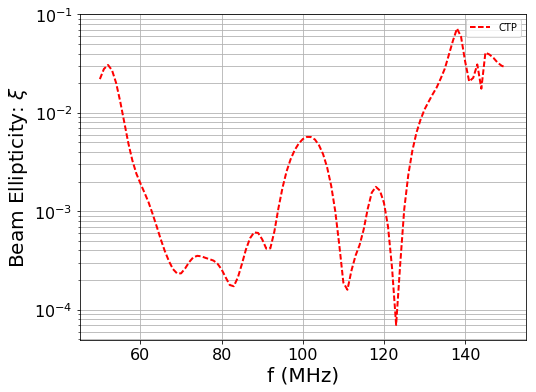

In [11]:
#print bSinuousBand.ellipticity
#p.plot(bSinuousBand.fAxis/1e6,(bSinuousBand.ellipticity),label='Band',color='k',ls='-',lw=2)
p.plot(bFineFrequency.fAxis/1e6,(bFineFrequency.ellipticity),label='CTP',color='r',ls='--',lw=2)


#p.plot(FeedPickets.fAxis/1e6,(FeedPickets.davePol),label='Picket Feed',color='grey',ls='-',lw=2)
#p.plot(FeedHighBand.fAxis/1e6-50,(FeedHighBand.beamFeedAndDish.ellipticity),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
#p.plot(FeedCTPShort.fAxis/1e6,(FeedCTPShort.beamFeedAndDish.ellipticity),label='CTP Short',color='r',ls='-',lw=2)
#p.plot(FeedCTPShortNoGap.fAxis/1e6,(FeedCTPShortNoGap.beamFeedAndDish.ellipticity),label='CTP Short No Gap',color='grey',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Beam Ellipticity: $\\xi$',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()

p.savefig('../analysis/CTP_Polarization_fineFrequency.pdf',bbox_inches='tight')

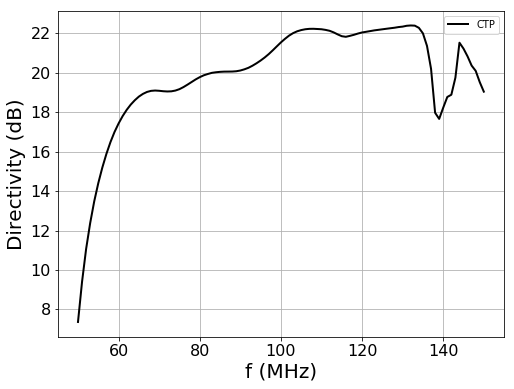

In [12]:
#print FeedPickets.daveBeamEfficiency.shape
p.plot(bFineFrequency.fAxis/1e6,10.*n.log10(4.*n.pi/bFineFrequency.solidAngles[0,:]),label='CTP',color='k',ls='-',lw=2)


#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedBackPlane.gain),label='Feed with Backplane only',color='grey',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Directivity (dB)',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
#p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()

p.savefig('../analysis/CTP_Directivity_fineFrequency.pdf',bbox_inches='tight')

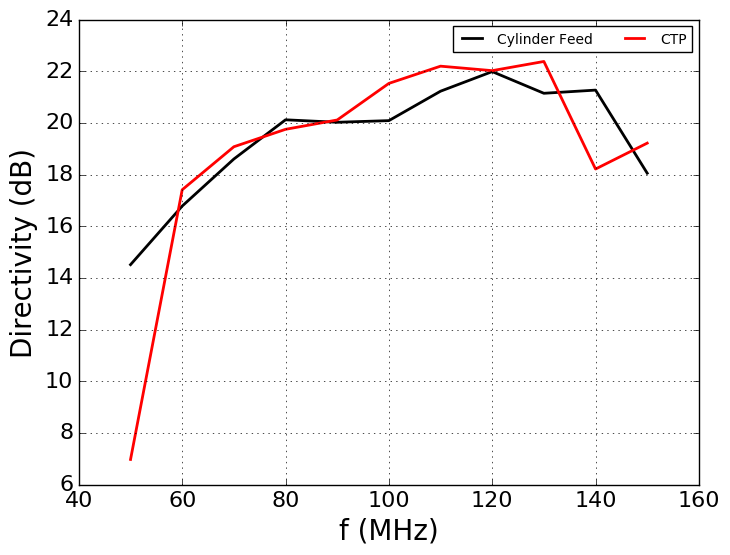

In [18]:
#print FeedPickets.daveBeamEfficiency.shape
p.plot(FeedCylinder.fAxis/1e6,10.*n.log10(FeedCylinder.gain),label='Cylinder Feed',color='k',ls='-',lw=2)
#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedPickets.gain),label='Picket Feed',color='grey',ls='-',lw=2)
#p.plot(FeedHighBand.fAxis/1e6-50,10.*n.log10(FeedHighBand.gain),label='High Band (100-200MHz)',color='k',ls='--',lw=2)


#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedBackPlane.gain),label='Feed with Backplane only',color='grey',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Directivity (dB)',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
#p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
#p.savefig('../analysis/Directivity.pdf',bbox_inches='tight')

(11,)


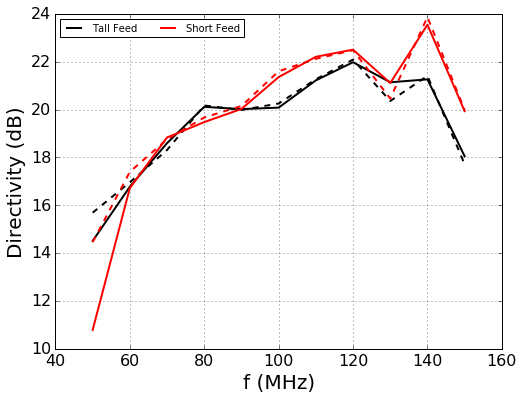

In [26]:
print FeedPickets.daveBeamEfficiency.shape
l0=p.plot(FeedCylinder.fAxis/1e6,10.*n.log10(FeedCylinder.gain),label='Cylinder Feed',color='k',lw=2,ls='-')[0]
p.plot(FeedCylinderNoGap.fAxis/1e6,10.*n.log10(FeedCylinderNoGap.gain),color='k',ls='--',lw=2)
#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedPickets.gain),label='Picket Feed',color='grey',ls='-',lw=2)
l1=p.plot(FeedCylinderShortGap.fAxis/1e6,10.*n.log10(FeedCylinderShortGap.gain),color='r',lw=2,ls='-')[0]
p.plot(FeedCylinderShortNoGap.fAxis/1e6,10.*n.log10(FeedCylinderShortNoGap.gain),label='Short Cylinder Feed\n No Gap',color='r',ls='--',lw=2)
#p.plot(FeedHighBand.fAxis/1e6-50,10.*n.log10(FeedHighBand.gain),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
#p.plot(FeedCylinderShortNoGap.fAxis/1e6,10.*n.log10(FeedCylinderShortNoGap.gain),label='Cylinder Feed',color='r',ls='-',lw=2)


#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedBackPlane.gain),label='Feed with Backplane only',color='grey',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Directivity (dB)',fontsize=20)
p.gca().legend((l0,l1),('Tall Feed','Short Feed'),loc='best',fontsize=10,ncol=2)
#p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
p.savefig('../analysis/DirectivityCompareGap.pdf',bbox_inches='tight')

(11,)


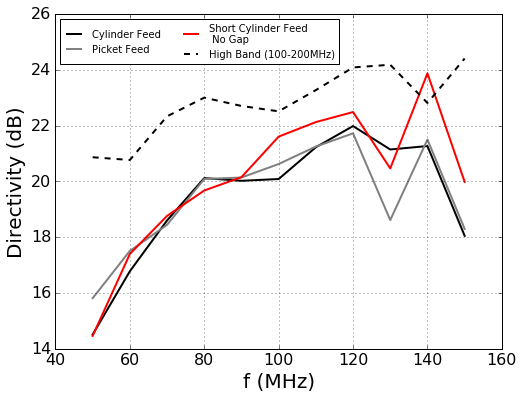

In [5]:
print FeedPickets.daveBeamEfficiency.shape
p.plot(FeedCylinder.fAxis/1e6,10.*n.log10(FeedCylinder.gain),label='Cylinder Feed',color='k',ls='-',lw=2)
p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedPickets.gain),label='Picket Feed',color='grey',ls='-',lw=2)
p.plot(FeedCylinderShortNoGap.fAxis/1e6,10.*n.log10(FeedCylinderShortNoGap.gain),label='Short Cylinder Feed\n No Gap',color='r',ls='-',lw=2)
p.plot(FeedHighBand.fAxis/1e6-50,10.*n.log10(FeedHighBand.gain),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
#p.plot(FeedCylinderShortNoGap.fAxis/1e6,10.*n.log10(FeedCylinderShortNoGap.gain),label='Cylinder Feed',color='r',ls='-',lw=2)


#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedBackPlane.gain),label='Feed with Backplane only',color='grey',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Directivity (dB)',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=2)
#p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
p.savefig('../analysis/Directivity.pdf',bbox_inches='tight')

In [13]:
print FeedCTP.daveBeamEfficiency



[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


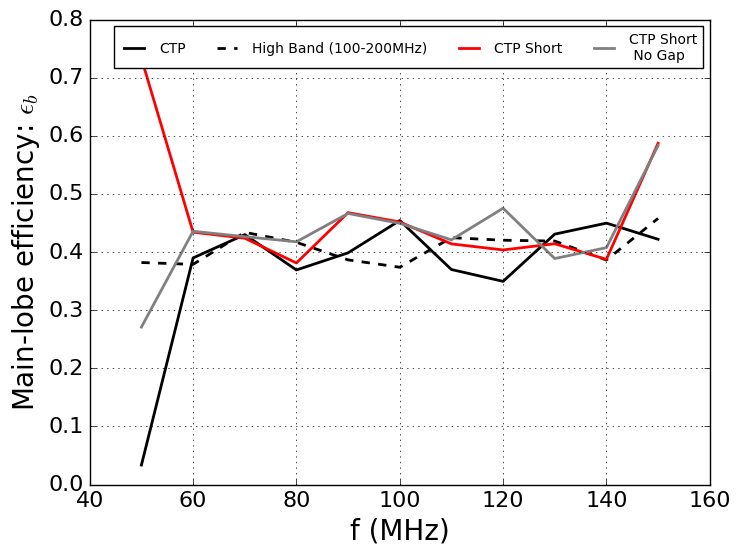

In [7]:

p.plot(FeedCTP.fAxis/1e6,(FeedCTP.daveBeamEfficiency),label='CTP',color='k',ls='-',lw=2)
#p.plot(FeedPickets.fAxis/1e6,(FeedPickets.daveBeamEfficiency),label='Picket Feed',color='grey',ls='-',lw=2)
p.plot(FeedHighBand.fAxis/1e6-50,(FeedHighBand.daveBeamEfficiency),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
p.plot(FeedCTPShort.fAxis/1e6,(FeedCTPShort.daveBeamEfficiency),label='CTP Short',color='r',ls='-',lw=2)

p.plot(FeedCTPShortNoGap.fAxis/1e6,(FeedCTPShortNoGap.daveBeamEfficiency),label='CTP Short\n No Gap',color='grey',ls='-',lw=2)


#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Main-lobe efficiency: $\\epsilon_b$',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
#p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
p.savefig('../analysis/Efficiency_CTP_Only.pdf',bbox_inches='tight')

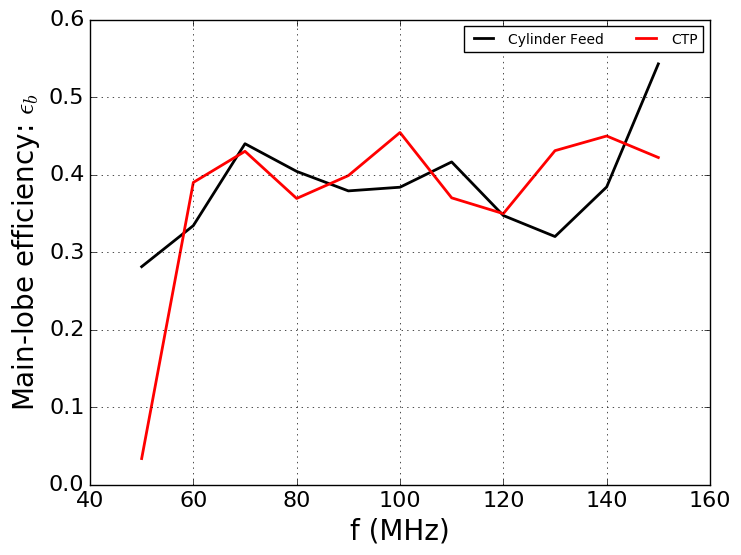

In [19]:

p.plot(FeedCylinder.fAxis/1e6,(FeedCylinder.daveBeamEfficiency),label='Cylinder Feed',color='k',ls='-',lw=2)
#p.plot(FeedPickets.fAxis/1e6,(FeedPickets.daveBeamEfficiency),label='Picket Feed',color='grey',ls='-',lw=2)
#p.plot(FeedHighBand.fAxis/1e6-50,(FeedHighBand.daveBeamEfficiency),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
p.plot(FeedCTP.fAxis/1e6,(FeedCTP.daveBeamEfficiency),label='CTP',color='r',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Main-lobe efficiency: $\\epsilon_b$',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
#p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
#p.savefig('../analysis/Efficiency.pdf',bbox_inches='tight')

(11,)


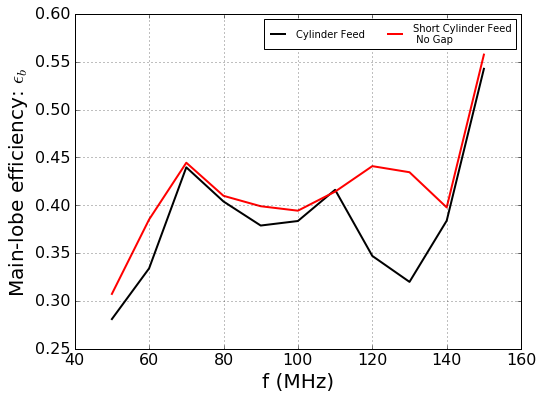

In [9]:
print FeedPickets.daveBeamEfficiency.shape

p.plot(FeedCylinder.fAxis/1e6,(FeedCylinder.daveBeamEfficiency),label='Cylinder Feed',color='k',ls='-',lw=2)
#p.plot(FeedPickets.fAxis/1e6,(FeedPickets.daveBeamEfficiency),label='Picket Feed',color='grey',ls='-',lw=2)
#p.plot(FeedHighBand.fAxis/1e6-50,(FeedHighBand.daveBeamEfficiency),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
p.plot(FeedCylinderShortNoGap.fAxis/1e6,(FeedCylinderShortNoGap.daveBeamEfficiency),label='Short Cylinder Feed\n No Gap',color='r',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Main-lobe efficiency: $\\epsilon_b$',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
#p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
#p.savefig('../analysis/Efficiency.pdf',bbox_inches='tight')

(11,)


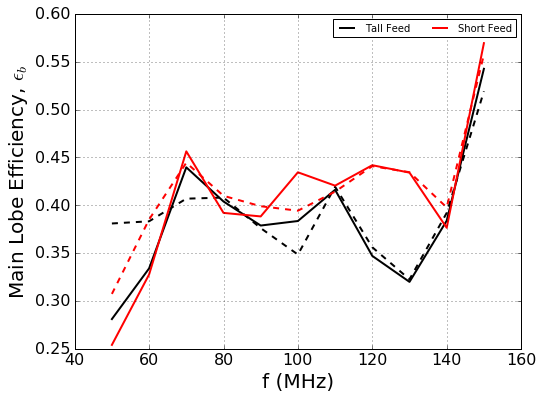

In [28]:
print FeedPickets.daveBeamEfficiency.shape
l0=p.plot(FeedCylinder.fAxis/1e6,(FeedCylinder.daveBeamEfficiency),label='Cylinder Feed',color='k',lw=2,ls='-')[0]
p.plot(FeedCylinderNoGap.fAxis/1e6,(FeedCylinderNoGap.daveBeamEfficiency),color='k',ls='--',lw=2)
#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedPickets.gain),label='Picket Feed',color='grey',ls='-',lw=2)
l1=p.plot(FeedCylinderShortGap.fAxis/1e6,(FeedCylinderShortGap.daveBeamEfficiency),color='r',lw=2,ls='-')[0]
p.plot(FeedCylinderShortNoGap.fAxis/1e6,(FeedCylinderShortNoGap.daveBeamEfficiency),label='Short Cylinder Feed\n No Gap',color='r',ls='--',lw=2)
#p.plot(FeedHighBand.fAxis/1e6-50,10.*n.log10(FeedHighBand.gain),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
#p.plot(FeedCylinderShortNoGap.fAxis/1e6,10.*n.log10(FeedCylinderShortNoGap.gain),label='Cylinder Feed',color='r',ls='-',lw=2)


#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedBackPlane.gain),label='Feed with Backplane only',color='grey',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Main Lobe Efficiency, $\\epsilon_b$',fontsize=20)
p.gca().legend((l0,l1),('Tall Feed','Short Feed'),loc='best',fontsize=10,ncol=2)
#p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
p.savefig('../analysis/EfficiencyCompareGap.pdf',bbox_inches='tight')

(11,)


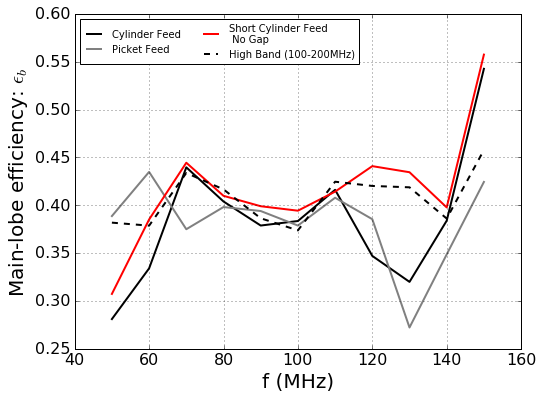

In [6]:
print FeedPickets.daveBeamEfficiency.shape

p.plot(FeedCylinder.fAxis/1e6,(FeedCylinder.daveBeamEfficiency),label='Cylinder Feed',color='k',ls='-',lw=2)
p.plot(FeedPickets.fAxis/1e6,(FeedPickets.daveBeamEfficiency),label='Picket Feed',color='grey',ls='-',lw=2)
p.plot(FeedCylinderShortNoGap.fAxis/1e6,(FeedCylinderShortNoGap.daveBeamEfficiency),label='Short Cylinder Feed\n No Gap',color='r',ls='-',lw=2)

p.plot(FeedHighBand.fAxis/1e6-50,(FeedHighBand.daveBeamEfficiency),label='High Band (100-200MHz)',color='k',ls='--',lw=2)


#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Main-lobe efficiency: $\\epsilon_b$',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=2)
#p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
p.savefig('../analysis/Efficiency.pdf',bbox_inches='tight')

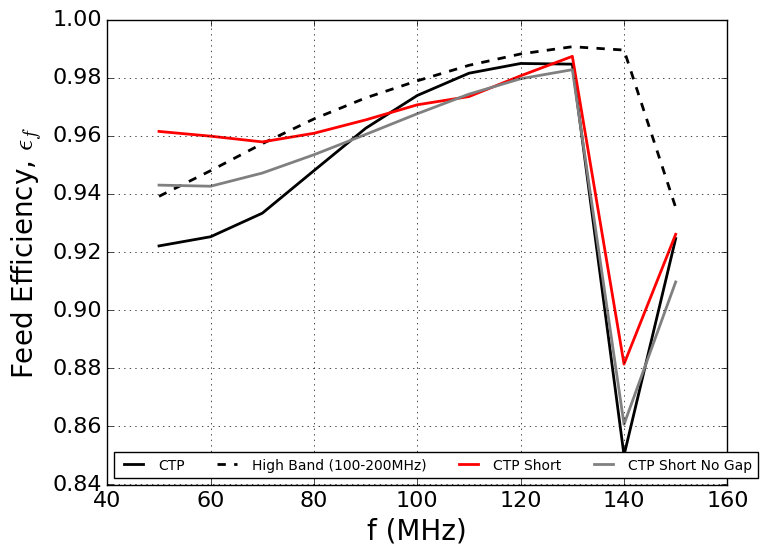

In [4]:
#print FeedPickets.daveBeamEfficiency.shape
p.plot(FeedCTP.fAxis/1e6,(FeedCTP.daveFeedEfficiency),label='CTP',color='k',ls='-',lw=2)
#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedPickets.gain),label='Picket Feed',color='grey',ls='-',lw=2)
p.plot(FeedHighBand.fAxis/1e6-50,(FeedHighBand.daveFeedEfficiency),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
p.plot(FeedCTPShort.fAxis/1e6,(FeedCTPShort.daveFeedEfficiency),label='CTP Short',color='r',ls='-',lw=2)
p.plot(FeedCTPShortNoGap.fAxis/1e6,(FeedCTPShortNoGap.daveFeedEfficiency),label='CTP Short No Gap',color='grey',ls='-',lw=2)


#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedBackPlane.gain),label='Feed with Backplane only',color='grey',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Feed Efficiency, $\\epsilon_f$',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
#p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
p.savefig('../analysis/feedEfficiency_CTP_Only.pdf',bbox_inches='tight')

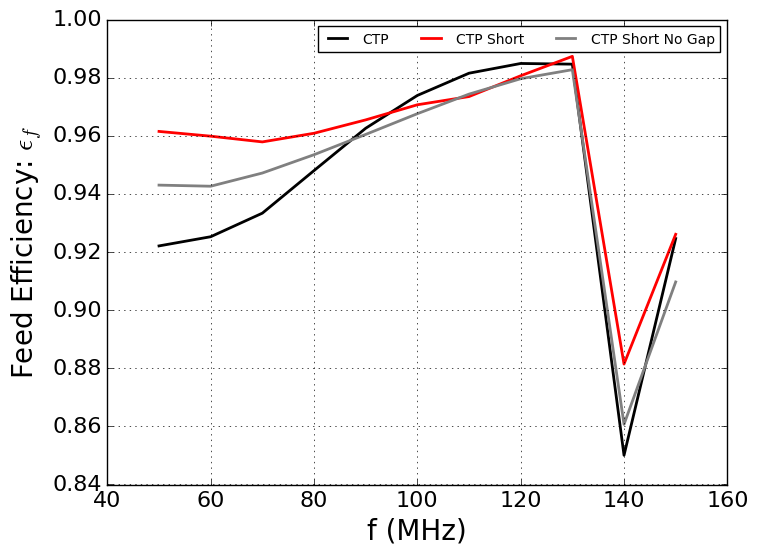

In [9]:
#print FeedPickets.daveFeedEfficiency.shape
p.plot(FeedCTP.fAxis/1e6,FeedCTP.daveFeedEfficiency,label='CTP',color='k',ls='-',lw=2)
#p.plot(FeedPickets.fAxis/1e6,FeedPickets.daveFeedEfficiency,label='Picket Feed',color='grey',ls='-',lw=2)
#p.plot(FeedHighBand.fAxis/1e6-50,(FeedHighBand.daveFeedEfficiency),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
p.plot(FeedCTPShort.fAxis/1e6,(FeedCTPShort.daveFeedEfficiency),label='CTP Short',color='r',ls='-',lw=2)
p.plot(FeedCTPShortNoGap.fAxis/1e6,(FeedCTPShortNoGap.daveFeedEfficiency),label='CTP Short No Gap',color='grey',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Feed Efficiency: $\\epsilon_f$',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
#p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
#p.savefig('../analysis/feedEfficiency.pdf',bbox_inches='tight')

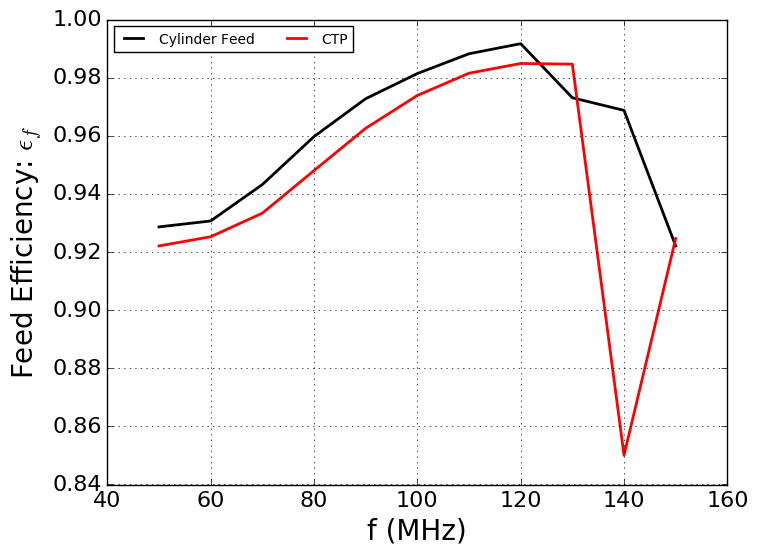

In [22]:
#print FeedPickets.daveFeedEfficiency.shape
p.plot(FeedCylinder.fAxis/1e6,FeedCylinder.daveFeedEfficiency,label='Cylinder Feed',color='k',ls='-',lw=2)
#p.plot(FeedPickets.fAxis/1e6,FeedPickets.daveFeedEfficiency,label='Picket Feed',color='grey',ls='-',lw=2)
#p.plot(FeedHighBand.fAxis/1e6-50,(FeedHighBand.daveFeedEfficiency),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
p.plot(FeedCTP.fAxis/1e6,(FeedCTP.daveFeedEfficiency),label='CTP',color='r',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Feed Efficiency: $\\epsilon_f$',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
#p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
#p.savefig('../analysis/feedEfficiency.pdf',bbox_inches='tight')

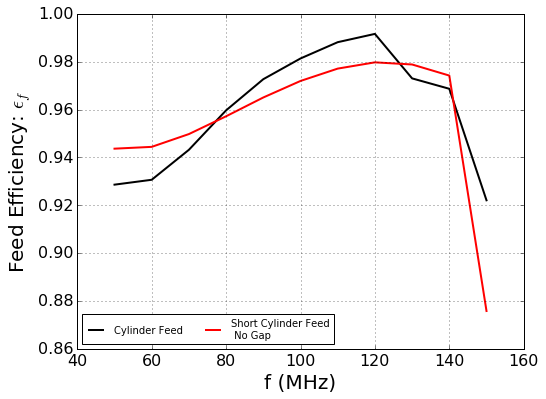

In [10]:
#print FeedPickets.daveFeedEfficiency.shape
p.plot(FeedCylinder.fAxis/1e6,FeedCylinder.daveFeedEfficiency,label='Cylinder Feed',color='k',ls='-',lw=2)
#p.plot(FeedPickets.fAxis/1e6,FeedPickets.daveFeedEfficiency,label='Picket Feed',color='grey',ls='-',lw=2)
#p.plot(FeedHighBand.fAxis/1e6-50,(FeedHighBand.daveFeedEfficiency),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
p.plot(FeedCylinderShortNoGap.fAxis/1e6,(FeedCylinderShortNoGap.daveFeedEfficiency),label='Short Cylinder Feed\n No Gap',color='r',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Feed Efficiency: $\\epsilon_f$',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
#p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
#p.savefig('../analysis/feedEfficiency.pdf',bbox_inches='tight')

(11,)


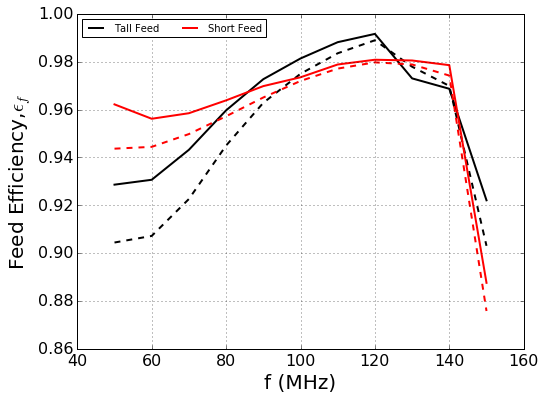

In [27]:
print FeedPickets.daveBeamEfficiency.shape
l0=p.plot(FeedCylinder.fAxis/1e6,(FeedCylinder.daveFeedEfficiency),label='Cylinder Feed',color='k',lw=2,ls='-')[0]
p.plot(FeedCylinderNoGap.fAxis/1e6,(FeedCylinderNoGap.daveFeedEfficiency),color='k',ls='--',lw=2)
#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedPickets.gain),label='Picket Feed',color='grey',ls='-',lw=2)
l1=p.plot(FeedCylinderShortGap.fAxis/1e6,(FeedCylinderShortGap.daveFeedEfficiency),color='r',lw=2,ls='-')[0]
p.plot(FeedCylinderShortNoGap.fAxis/1e6,(FeedCylinderShortNoGap.daveFeedEfficiency),label='Short Cylinder Feed\n No Gap',color='r',ls='--',lw=2)
#p.plot(FeedHighBand.fAxis/1e6-50,10.*n.log10(FeedHighBand.gain),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
#p.plot(FeedCylinderShortNoGap.fAxis/1e6,10.*n.log10(FeedCylinderShortNoGap.gain),label='Cylinder Feed',color='r',ls='-',lw=2)


#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedBackPlane.gain),label='Feed with Backplane only',color='grey',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Feed Efficiency,$\\epsilon_f$',fontsize=20)
p.gca().legend((l0,l1),('Tall Feed','Short Feed'),loc='best',fontsize=10,ncol=2)
#p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
p.savefig('../analysis/feedEfficiencyCompareGap.pdf',bbox_inches='tight')

(11,)


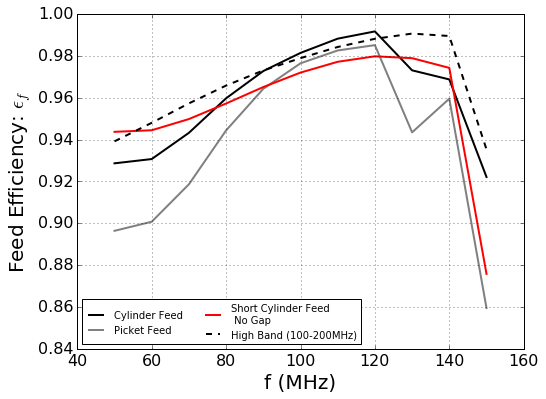

In [7]:
print FeedPickets.daveFeedEfficiency.shape
p.plot(FeedCylinder.fAxis/1e6,FeedCylinder.daveFeedEfficiency,label='Cylinder Feed',color='k',ls='-',lw=2)
p.plot(FeedPickets.fAxis/1e6,FeedPickets.daveFeedEfficiency,label='Picket Feed',color='grey',ls='-',lw=2)
p.plot(FeedCylinderShortNoGap.fAxis/1e6,(FeedCylinderShortNoGap.daveFeedEfficiency),label='Short Cylinder Feed\n No Gap',color='r',ls='-',lw=2)
p.plot(FeedHighBand.fAxis/1e6-50,(FeedHighBand.daveFeedEfficiency),label='High Band (100-200MHz)',color='k',ls='--',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Feed Efficiency: $\\epsilon_f$',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=2)
#p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
p.savefig('../analysis/feedEfficiency.pdf',bbox_inches='tight')

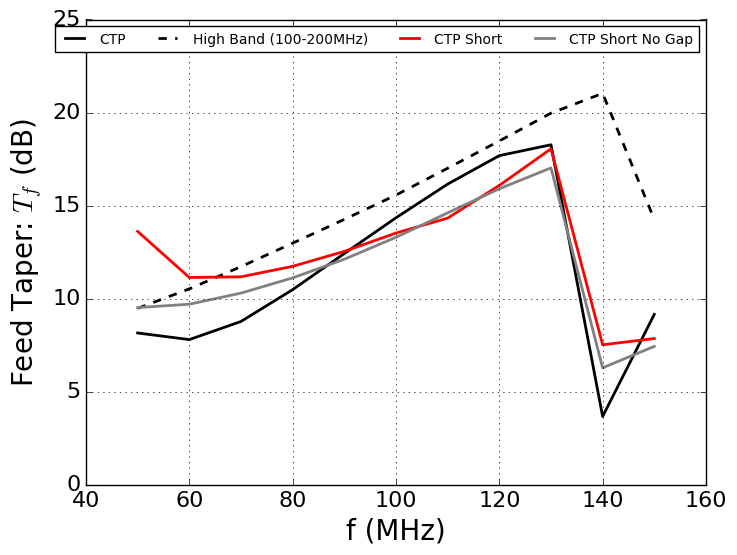

In [8]:
p.plot(FeedCTP.fAxis/1e6,10.*n.log10(FeedCTP.daveTaper),label='CTP',color='k',ls='-',lw=2)
#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedPickets.daveTaper),label='Picket Feed',color='grey',ls='-',lw=2)
p.plot(FeedHighBand.fAxis/1e6-50,10.*n.log10(FeedHighBand.daveTaper),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
p.plot(FeedCTPShort.fAxis/1e6,10.*n.log10(FeedCTPShort.daveTaper),label='CTP Short',color='r',ls='-',lw=2)
p.plot(FeedCTPShortNoGap.fAxis/1e6,10.*n.log10(FeedCTPShortNoGap.daveTaper),label='CTP Short No Gap',color='grey',ls='-',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Feed Taper: $T_f$ (dB)',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
#p.ylim(0,22)
p.savefig('../analysis/feedTaper_CTP.pdf',bbox_inches='tight')




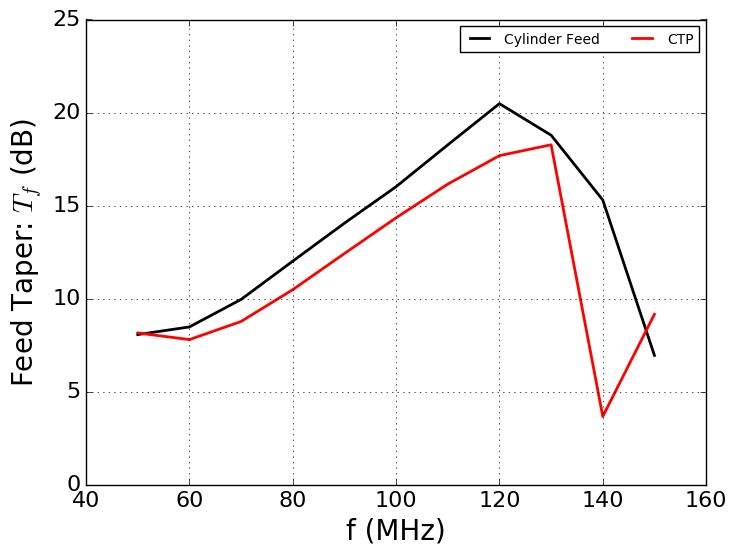

In [23]:
p.plot(FeedCylinder.fAxis/1e6,10.*n.log10(FeedCylinder.daveTaper),label='Cylinder Feed',color='k',ls='-',lw=2)
#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedPickets.daveTaper),label='Picket Feed',color='grey',ls='-',lw=2)
#p.plot(FeedHighBand.fAxis/1e6-50,10.*n.log10(FeedHighBand.daveTaper),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
p.plot(FeedCTP.fAxis/1e6,10.*n.log10(FeedCTP.daveTaper),label='CTP',color='r',ls='-',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Feed Taper: $T_f$ (dB)',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
#p.ylim(0,22)
#p.savefig('../analysis/feedTaper.pdf',bbox_inches='tight')




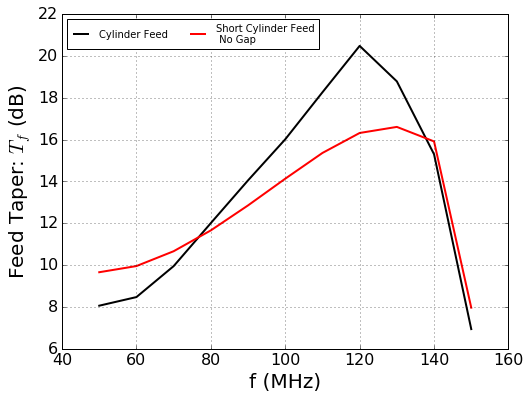

In [11]:
p.plot(FeedCylinder.fAxis/1e6,10.*n.log10(FeedCylinder.daveTaper),label='Cylinder Feed',color='k',ls='-',lw=2)
#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedPickets.daveTaper),label='Picket Feed',color='grey',ls='-',lw=2)
#p.plot(FeedHighBand.fAxis/1e6-50,10.*n.log10(FeedHighBand.daveTaper),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
p.plot(FeedCylinderShortNoGap.fAxis/1e6,10.*n.log10(FeedCylinderShortNoGap.daveTaper),label='Short Cylinder Feed\n No Gap',color='r',ls='-',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Feed Taper: $T_f$ (dB)',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
#p.ylim(0,22)
#p.savefig('../analysis/feedTaper.pdf',bbox_inches='tight')



(11,)


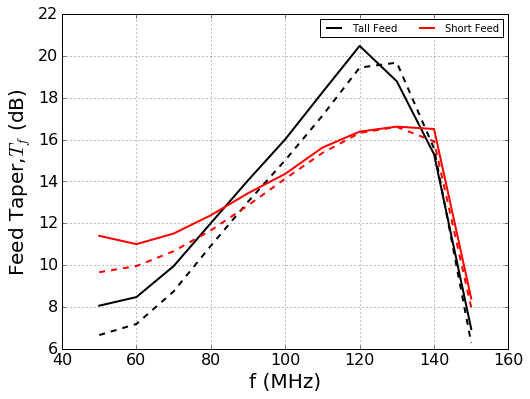

In [30]:
print FeedPickets.daveBeamEfficiency.shape
l0=p.plot(FeedCylinder.fAxis/1e6,10.*n.log10(FeedCylinder.daveTaper),label='Cylinder Feed',color='k',lw=2,ls='-')[0]
p.plot(FeedCylinderNoGap.fAxis/1e6,10.*n.log10(FeedCylinderNoGap.daveTaper),color='k',ls='--',lw=2)
#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedPickets.gain),label='Picket Feed',color='grey',ls='-',lw=2)
l1=p.plot(FeedCylinderShortGap.fAxis/1e6,10.*n.log10(FeedCylinderShortGap.daveTaper),color='r',lw=2,ls='-')[0]
p.plot(FeedCylinderShortNoGap.fAxis/1e6,10.*n.log10(FeedCylinderShortNoGap.daveTaper),label='Short Cylinder Feed\n No Gap',color='r',ls='--',lw=2)
#p.plot(FeedHighBand.fAxis/1e6-50,10.*n.log10(FeedHighBand.gain),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
#p.plot(FeedCylinderShortNoGap.fAxis/1e6,10.*n.log10(FeedCylinderShortNoGap.gain),label='Cylinder Feed',color='r',ls='-',lw=2)


#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedBackPlane.gain),label='Feed with Backplane only',color='grey',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Feed Taper,$T_f$ (dB)',fontsize=20)
p.gca().legend((l0,l1),('Tall Feed','Short Feed'),loc='best',fontsize=10,ncol=2)
#p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
p.savefig('../analysis/feedTaperCompareGap.pdf',bbox_inches='tight')

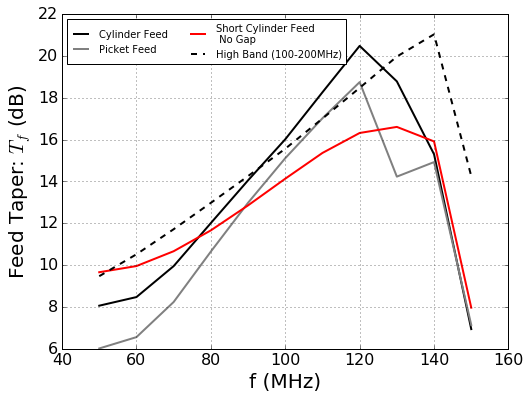

In [8]:
p.plot(FeedCylinder.fAxis/1e6,10.*n.log10(FeedCylinder.daveTaper),label='Cylinder Feed',color='k',ls='-',lw=2)
p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedPickets.daveTaper),label='Picket Feed',color='grey',ls='-',lw=2)
p.plot(FeedCylinderShortNoGap.fAxis/1e6,10.*n.log10(FeedCylinderShortNoGap.daveTaper),label='Short Cylinder Feed\n No Gap',color='r',ls='-',lw=2)

p.plot(FeedHighBand.fAxis/1e6-50,10.*n.log10(FeedHighBand.daveTaper),label='High Band (100-200MHz)',color='k',ls='--',lw=2)


p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Feed Taper: $T_f$ (dB)',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=2)
p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
#p.ylim(0,22)
p.savefig('../analysis/feedTaper.pdf',bbox_inches='tight')


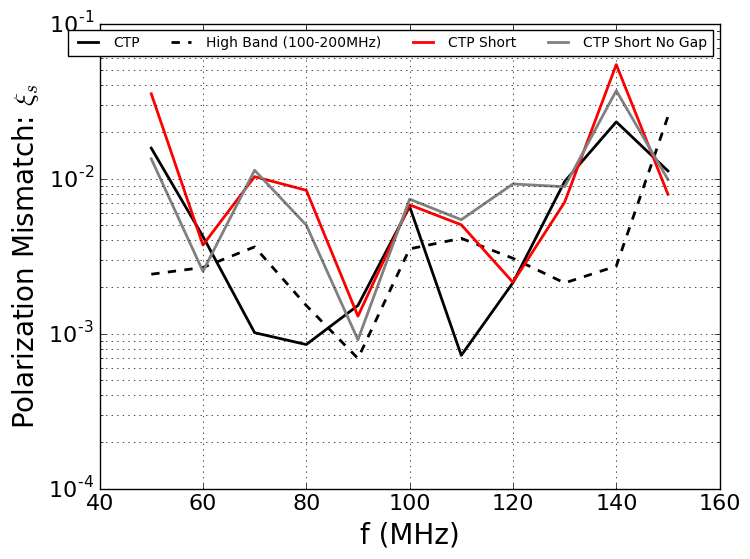

In [9]:

p.plot(FeedCTP.fAxis/1e6,(FeedCTP.davePol),label='CTP',color='k',ls='-',lw=2)
#p.plot(FeedPickets.fAxis/1e6,(FeedPickets.davePol),label='Picket Feed',color='grey',ls='-',lw=2)
p.plot(FeedHighBand.fAxis/1e6-50,(FeedHighBand.davePol),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
p.plot(FeedCTPShort.fAxis/1e6,(FeedCTPShort.davePol),label='CTP Short',color='r',ls='-',lw=2)
p.plot(FeedCTPShortNoGap.fAxis/1e6,(FeedCTPShortNoGap.davePol),label='CTP Short No Gap',color='grey',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Polarization Mismatch: $\\xi_s$',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
p.savefig('../analysis/PolarizationSimple_CTP.pdf',bbox_inches='tight')

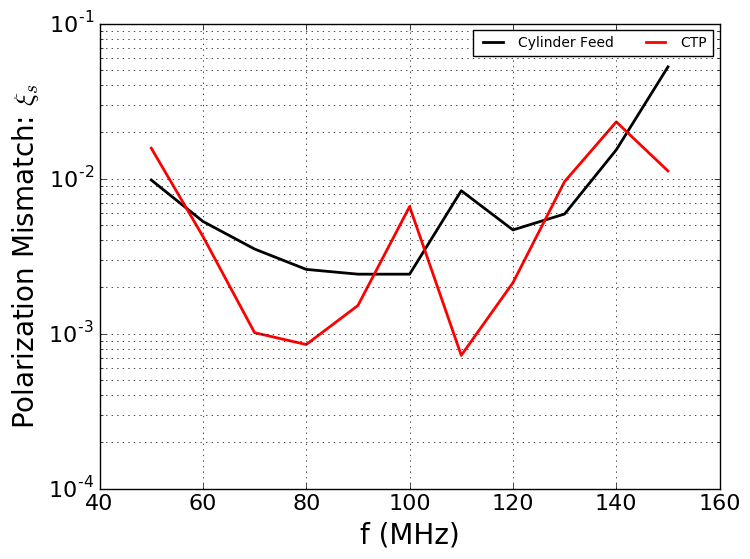

In [24]:

p.plot(FeedCylinder.fAxis/1e6,(FeedCylinder.davePol),label='Cylinder Feed',color='k',ls='-',lw=2)
#p.plot(FeedPickets.fAxis/1e6,(FeedPickets.davePol),label='Picket Feed',color='grey',ls='-',lw=2)
p.plot(FeedHighBand.fAxis/1e6-50,(FeedHighBand.davePol),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
p.plot(FeedCTP.fAxis/1e6,(FeedCTP.davePol),label='CTP',color='r',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Polarization Mismatch: $\\xi_s$',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
p.savefig('../analysis/PolarizationSimple_CTP.pdf',bbox_inches='tight')

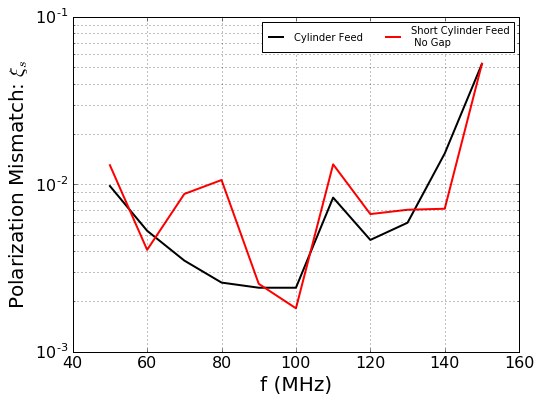

In [12]:

p.plot(FeedCylinder.fAxis/1e6,(FeedCylinder.davePol),label='Cylinder Feed',color='k',ls='-',lw=2)
#p.plot(FeedPickets.fAxis/1e6,(FeedPickets.davePol),label='Picket Feed',color='grey',ls='-',lw=2)
#p.plot(FeedHighBand.fAxis/1e6-50,(FeedHighBand.davePol),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
p.plot(FeedCylinderShortNoGap.fAxis/1e6,(FeedCylinderShortNoGap.davePol),label='Short Cylinder Feed\n No Gap',color='r',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Polarization Mismatch: $\\xi_s$',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
#p.savefig('../analysis/PolarizationSimple.pdf',bbox_inches='tight')

(11,)


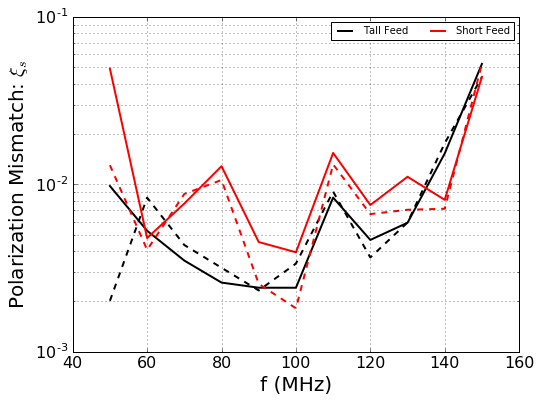

In [31]:
print FeedPickets.daveBeamEfficiency.shape
l0=p.plot(FeedCylinder.fAxis/1e6,(FeedCylinder.davePol),label='Cylinder Feed',color='k',lw=2,ls='-')[0]
p.plot(FeedCylinderNoGap.fAxis/1e6,(FeedCylinderNoGap.davePol),color='k',ls='--',lw=2)
#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedPickets.gain),label='Picket Feed',color='grey',ls='-',lw=2)
l1=p.plot(FeedCylinderShortGap.fAxis/1e6,(FeedCylinderShortGap.davePol),color='r',lw=2,ls='-')[0]
p.plot(FeedCylinderShortNoGap.fAxis/1e6,(FeedCylinderShortNoGap.davePol),label='Short Cylinder Feed\n No Gap',color='r',ls='--',lw=2)
#p.plot(FeedHighBand.fAxis/1e6-50,10.*n.log10(FeedHighBand.gain),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
#p.plot(FeedCylinderShortNoGap.fAxis/1e6,10.*n.log10(FeedCylinderShortNoGap.gain),label='Cylinder Feed',color='r',ls='-',lw=2)


#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedBackPlane.gain),label='Feed with Backplane only',color='grey',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Polarization Mismatch: $\\xi_s$',fontsize=20)
p.gca().legend((l0,l1),('Tall Feed','Short Feed'),loc='best',fontsize=10,ncol=2)
p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
p.savefig('../analysis/PolarizationSimpleCompareGap.pdf',bbox_inches='tight')

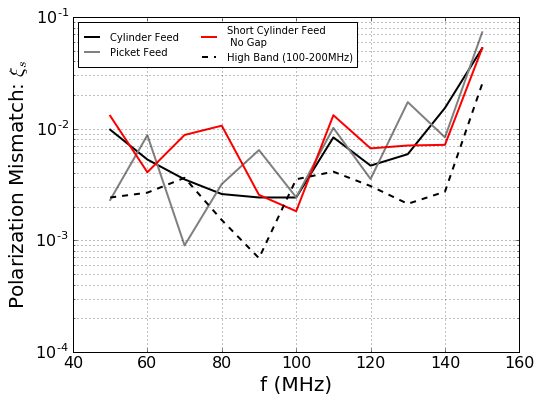

In [9]:

p.plot(FeedCylinder.fAxis/1e6,(FeedCylinder.davePol),label='Cylinder Feed',color='k',ls='-',lw=2)
p.plot(FeedPickets.fAxis/1e6,(FeedPickets.davePol),label='Picket Feed',color='grey',ls='-',lw=2)
p.plot(FeedCylinderShortNoGap.fAxis/1e6,(FeedCylinderShortNoGap.davePol),label='Short Cylinder Feed\n No Gap',color='r',ls='-',lw=2)

p.plot(FeedHighBand.fAxis/1e6-50,(FeedHighBand.davePol),label='High Band (100-200MHz)',color='k',ls='--',lw=2)


#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Polarization Mismatch: $\\xi_s$',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=2)
p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
p.savefig('../analysis/PolarizationSimple.pdf',bbox_inches='tight')

(11,)


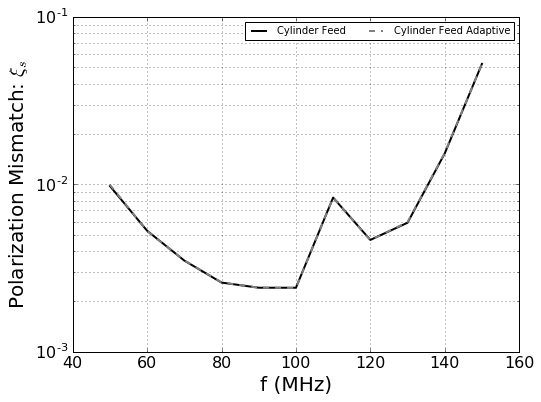

In [10]:
print FeedPickets.daveBeamEfficiency.shape

p.plot(FeedCylinder.fAxis/1e6,(FeedCylinder.davePol),label='Cylinder Feed',color='k',ls='-',lw=2)
p.plot(FeedCylinderAdaptive.fAxis/1e6,(FeedCylinderAdaptive.davePol),label='Cylinder Feed Adaptive',color='grey',ls='--',lw=2)


#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Polarization Mismatch: $\\xi_s$',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
#p.savefig('../analysis/PolarizationSimple.pdf',bbox_inches='tight')

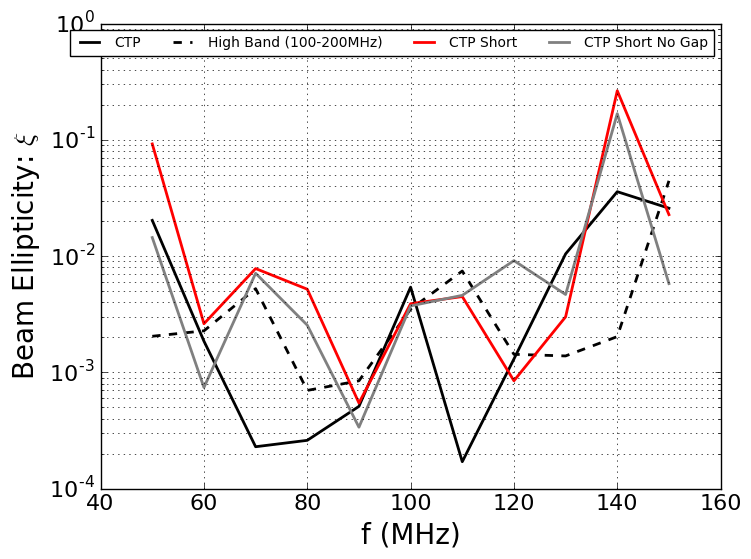

In [7]:

p.plot(FeedCTP.fAxis/1e6,(FeedCTP.beamFeedAndDish.ellipticity),label='CTP',color='k',ls='-',lw=2)
#p.plot(FeedPickets.fAxis/1e6,(FeedPickets.davePol),label='Picket Feed',color='grey',ls='-',lw=2)
p.plot(FeedHighBand.fAxis/1e6-50,(FeedHighBand.beamFeedAndDish.ellipticity),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
p.plot(FeedCTPShort.fAxis/1e6,(FeedCTPShort.beamFeedAndDish.ellipticity),label='CTP Short',color='r',ls='-',lw=2)
p.plot(FeedCTPShortNoGap.fAxis/1e6,(FeedCTPShortNoGap.beamFeedAndDish.ellipticity),label='CTP Short No Gap',color='grey',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Beam Ellipticity: $\\xi$',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
p.savefig('../analysis/Polarization_CTP.pdf',bbox_inches='tight')

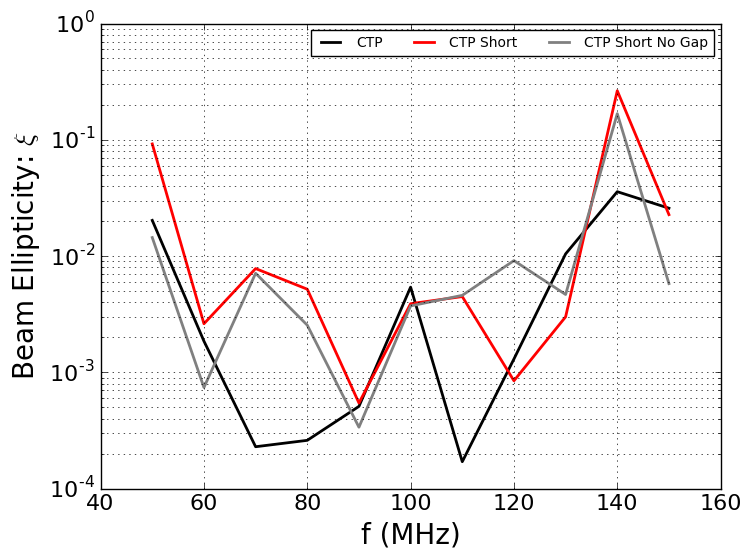

In [12]:

p.plot(FeedCTP.fAxis/1e6,(FeedCTP.beamFeedAndDish.ellipticity),label='CTP',color='k',ls='-',lw=2)
#p.plot(FeedPickets.fAxis/1e6,(FeedPickets.beamFeedAndDish.ellipticity),label='Picket Feed',color='grey',ls='-',lw=2)
p.plot(FeedCTPShort.fAxis/1e6,(FeedCTPShort.beamFeedAndDish.ellipticity),label='CTP Short',color='r',ls='-',lw=2)
p.plot(FeedCTPShortNoGap.fAxis/1e6,(FeedCTPShortNoGap.beamFeedAndDish.ellipticity),label='CTP Short No Gap',color='grey',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Beam Ellipticity: $\\xi$',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
#p.savefig('../analysis/Polarization.pdf',bbox_inches='tight')

(11,)


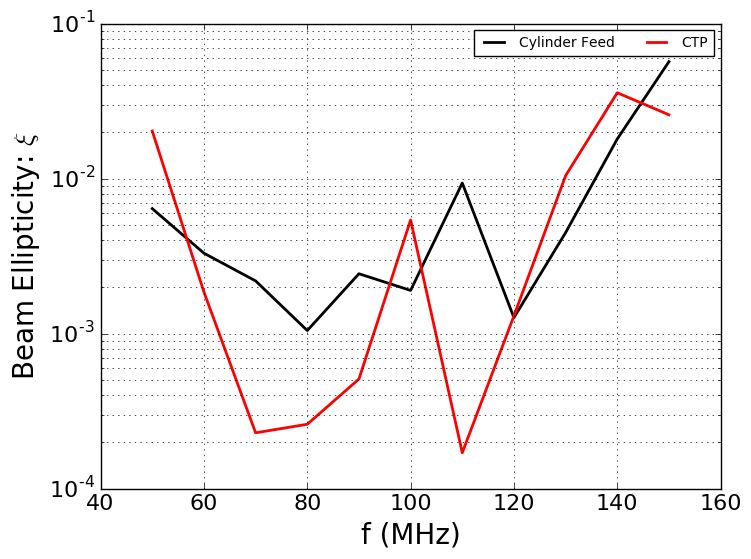

In [25]:
print FeedPickets.daveBeamEfficiency.shape

p.plot(FeedCylinder.fAxis/1e6,(FeedCylinder.beamFeedAndDish.ellipticity),label='Cylinder Feed',color='k',ls='-',lw=2)
#p.plot(FeedPickets.fAxis/1e6,(FeedPickets.beamFeedAndDish.ellipticity),label='Picket Feed',color='grey',ls='-',lw=2)
p.plot(FeedCTP.fAxis/1e6,(FeedCTP.beamFeedAndDish.ellipticity),label='CTP',color='r',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Beam Ellipticity: $\\xi$',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
#p.savefig('../analysis/Polarization.pdf',bbox_inches='tight')

(11,)


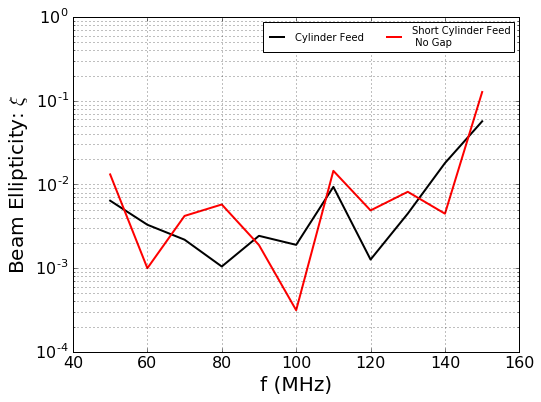

In [14]:
print FeedPickets.daveBeamEfficiency.shape

p.plot(FeedCylinder.fAxis/1e6,(FeedCylinder.beamFeedAndDish.ellipticity),label='Cylinder Feed',color='k',ls='-',lw=2)
#p.plot(FeedPickets.fAxis/1e6,(FeedPickets.beamFeedAndDish.ellipticity),label='Picket Feed',color='grey',ls='-',lw=2)
p.plot(FeedCylinderShortNoGap.fAxis/1e6,(FeedCylinderShortNoGap.beamFeedAndDish.ellipticity),label='Short Cylinder Feed\n No Gap',color='r',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Beam Ellipticity: $\\xi$',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=4)
p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
#p.savefig('../analysis/Polarization.pdf',bbox_inches='tight')

(11,)


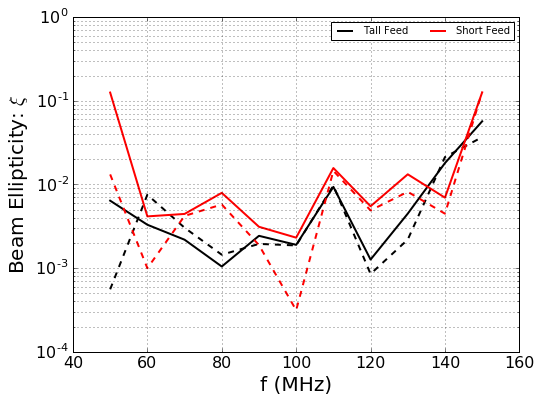

In [32]:
print FeedPickets.daveBeamEfficiency.shape
l0=p.plot(FeedCylinder.fAxis/1e6,(FeedCylinder.beamFeedAndDish.ellipticity),label='Cylinder Feed',color='k',lw=2,ls='-')[0]
p.plot(FeedCylinderNoGap.fAxis/1e6,(FeedCylinderNoGap.beamFeedAndDish.ellipticity),color='k',ls='--',lw=2)
#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedPickets.gain),label='Picket Feed',color='grey',ls='-',lw=2)
l1=p.plot(FeedCylinderShortGap.fAxis/1e6,(FeedCylinderShortGap.beamFeedAndDish.ellipticity),color='r',lw=2,ls='-')[0]
p.plot(FeedCylinderShortNoGap.fAxis/1e6,(FeedCylinderShortNoGap.beamFeedAndDish.ellipticity),label='Short Cylinder Feed\n No Gap',color='r',ls='--',lw=2)
#p.plot(FeedHighBand.fAxis/1e6-50,10.*n.log10(FeedHighBand.gain),label='High Band (100-200MHz)',color='k',ls='--',lw=2)
#p.plot(FeedCylinderShortNoGap.fAxis/1e6,10.*n.log10(FeedCylinderShortNoGap.gain),label='Cylinder Feed',color='r',ls='-',lw=2)


#p.plot(FeedPickets.fAxis/1e6,10.*n.log10(FeedBackPlane.gain),label='Feed with Backplane only',color='grey',ls='-',lw=2)



#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Beam Ellipticity: $\\xi$',fontsize=20)
p.gca().legend((l0,l1),('Tall Feed','Short Feed'),loc='best',fontsize=10,ncol=2)
p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
p.savefig('../analysis/PolarizationCompareGap.pdf',bbox_inches='tight')

(11,)


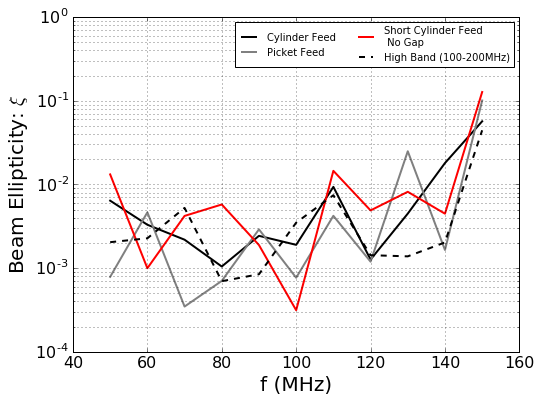

In [10]:
print FeedPickets.daveBeamEfficiency.shape

p.plot(FeedCylinder.fAxis/1e6,(FeedCylinder.beamFeedAndDish.ellipticity),label='Cylinder Feed',color='k',ls='-',lw=2)
p.plot(FeedPickets.fAxis/1e6,(FeedPickets.beamFeedAndDish.ellipticity),label='Picket Feed',color='grey',ls='-',lw=2)
p.plot(FeedCylinderShortNoGap.fAxis/1e6,(FeedCylinderShortNoGap.beamFeedAndDish.ellipticity),label='Short Cylinder Feed\n No Gap',color='r',ls='-',lw=2)
p.plot(FeedHighBand.fAxis/1e6-50,(FeedHighBand.beamFeedAndDish.ellipticity),label='High Band (100-200MHz)',color='k',ls='--',lw=2)


#print beamCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#print beamNoCylinder.ellipticity[beamNoCylinder.fAxis==100e6]
#p.plot(beamNoCylinder.fAxis/1e6,beamNoCylinder.ellipticity,label='HERA Dish\nNo Cylinder',color='k',ls='--',lw=2)
#p.plot(beamBareDipole.fAxis/1e6,beamBareDipole.ellipticity,label='HERA Dish\nDipole Only',color='grey',lw=2,ls='-')
#p.plot(beamPaneledCylinder.fAxis/1e6,beamPaneledCylinder.ellipticity,label='HERA Dish\nPaneled Cylinder',color='grey',lw=2,ls='--')
#p.plot(beamCylinderV2.fAxis/1e6,beamCylinder.ellipticity,label='HERA Dish v2',color='k',ls=':',lw=2)



p.xlabel('f (MHz)',fontsize=20)
p.ylabel('Beam Ellipticity: $\\xi$',fontsize=20)
p.legend(loc='best',fontsize=10,ncol=2)
p.yscale('log')
#p.ylim(1e-4,1e0)

p.gca().tick_params('x',labelsize=16)
p.gca().tick_params('y',labelsize=16)
p.gcf().set_size_inches([8,6])
p.gca().yaxis.grid(which='minor')
p.grid()
p.savefig('../analysis/Polarization.pdf',bbox_inches='tight')